#                                 Exploratory Data Analysis for Credit Card Data

  * The purpose of this project is to explore the data and understand the customer spending and repayment behaviour

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from datetime import datetime

### Load the datasets and display

In [2]:
customer_df = pd.read_csv("Customer Acqusition.xls")
customer_spend = pd.read_csv("spend.xls")
customer_payment = pd.read_csv("Repayment.xls")


In [3]:
customer_df.head()

,No,Customer,Age,City,Product,Limit,Company,Segment
0,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed
1,2,A2,71,CALCUTTA,Silver,100000.0,C2,Salaried_MNC
2,3,A3,34,COCHIN,Platimum,10000.0,C3,Salaried_Pvt
3,4,A4,47,BOMBAY,Platimum,10001.0,C4,Govt
4,5,A5,56,BANGALORE,Platimum,10002.0,C5,Normal Salary


In [4]:
customer_spend.head()

,Sl No:,Customer,Month,Type,Amount
0,1,A1,12-Jan-04,JEWELLERY,485470.80
1,2,A1,3-Jan-04,PETRO,410556.13
2,3,A1,15-Jan-04,CLOTHES,23740.46
3,4,A1,25-Jan-04,FOOD,484342.47
4,5,A1,17-Jan-05,CAMERA,369694.07


In [5]:
customer_payment.head()

,SL No:,Customer,Month,Amount,Unnamed: 4
0,NaN,A1,12-Jan-04,495414.75,NaN
1,2.0,A1,3-Jan-04,245899.02,NaN
2,3.0,A1,15-Jan-04,259490.06,NaN
3,4.0,A1,25-Jan-04,437555.12,NaN
4,5.0,A1,17-Jan-05,165972.88,NaN


### Cleaning the data
This will include the following:
1. Drop unnecessary columns
      - "SL No."
      - "Unnamed: 4"
2. Remove any nulls 
3. Remove any duplicates
4. Check the validity of the remaining data by:
      -  Checking if any customers are under 18yrs of age
      -  Checking if customer spending exceeds the credit limit
* Splitting the "Month" column to "Day, Month, Year" columns
* Rename columns

**1. Drop unnecessary columns**

In [6]:
customer_df.drop(["No"], axis=1, inplace=True)
customer_spend.drop(["Sl No:"], axis=1, inplace=True)
customer_payment.drop(["SL No:", "Unnamed: 4"], axis=1, inplace=True)


**2. Check if any null values are present**

In [7]:
customer_df.isnull().values.sum()


0

In [8]:
customer_spend.isnull().values.sum()

0

In [9]:
customer_payment.isnull().sum()

Customer    23
Month       23
Amount      23
dtype: int64

In [10]:
# Drop the null rows in the customer_payment dataframe
customer_payment.dropna(how="all", axis=0, inplace=True)

customer_payment.isnull().values.sum()

0

**3. Check if there are any duplicates in customer data**


In [11]:
customer_df["Customer"].is_unique

True

**4. Check if the remaining data is valid**

In [12]:
# We can see that customers under 18 yrs are present
print(f"Number of customers under 18 years: {(customer_df['Age'] < 18).values.sum()}")

# We shall substitute these customers' ages with the average age of the dataset
average = customer_df.loc[customer_df["Age"] >= 18, "Age"].mean()
customer_df.loc[customer_df["Age"] < 18, "Age"] = int(average)

# Quick Check
# (customer_df['Age'] < 18).values.sum()


# Let's also check if some customers have an amount spent over their credit limit
# Merge the customer data with the spend data
merged_spending = customer_df.merge(right=customer_spend, how='inner', on='Customer')

print(f"Number of rows with spending over the limit: {(merged_spending['Amount'] > merged_spending['Limit']).values.sum()}")

# Substitute these values with the credit limit
merged_spending.loc[(merged_spending['Amount'] > merged_spending['Limit']), "Amount"] = merged_spending.loc[(merged_spending['Amount'] > merged_spending['Limit']), "Limit"]

# Quick Check
# (merged_spending['Spend Amount'] > merged_spending['Limit']).values.sum()

Number of customers under 18 years: 6
Number of rows with spending over the limit: 607


***Split the date**

In [13]:
# Convert the string date to datetime
def date_conversion(df):
    """The function converts the string dates in the specified dataframe to datetime format and appends to the dataframe"""
    full_date = df["Month"].apply(lambda x: datetime.strptime(x, '%d-%b-%y'))

    # Drop the month column before adding the new columns
    df.drop(["Month"], axis=1, inplace=True)

    # Add the new columns
    df["Day"] = full_date.apply(lambda d: d.day)
    df["Month"] = full_date.apply(lambda m: m.month)
    df["Year"] = full_date.apply(lambda y: y.year)
    df["Date"] = full_date

date_conversion(customer_spend)
date_conversion(customer_payment)


***Rename the Ambiguous columns**

In [14]:
# Rename the columns
customer_spend.rename(columns={"Type": "Product Bought", "Amount": "Spend Amount"}, inplace=True)
customer_payment.rename(columns={"Amount": "Payment Amount"}, inplace=True)

### Exploring the Data
When exploring the data, I will try and answer the following questions:
- What is the population distribution of the different segments?

##### 1. Checking the Customer Distribution In the Different Segments

<AxesSubplot:xlabel='Segment', ylabel='count'>

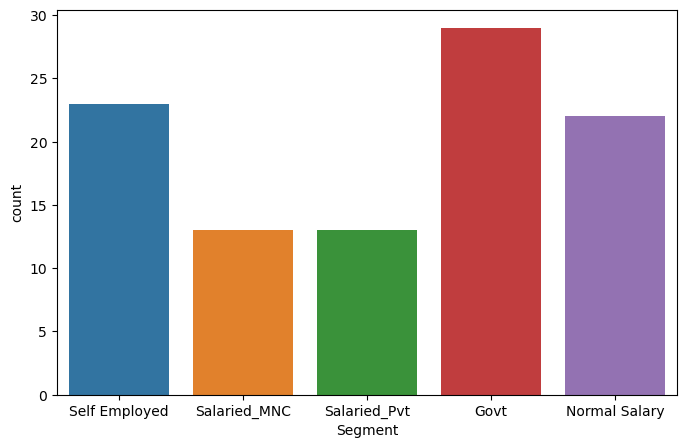

In [15]:
plt.figure(figsize=(8, 5))
sns.countplot(data=customer_df, x="Segment")

##### 2. Which segements have the highest credit limits?

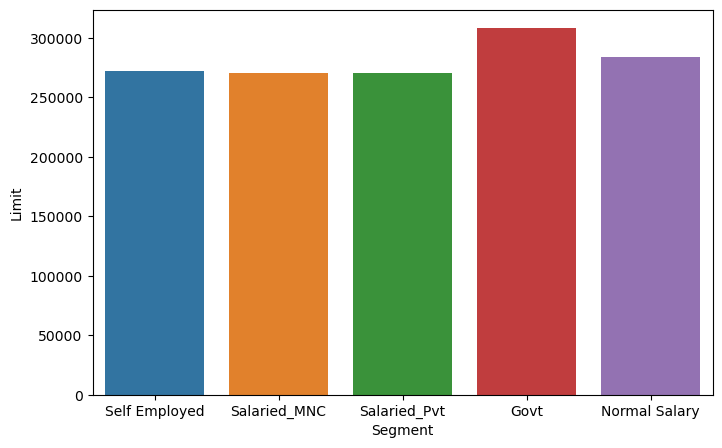

In [16]:
# Visualize using a bar graph
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x="Segment", y="Limit", data=customer_df, ci=None)

plt.show()

Government employees get higher credit limit compared to the rest while Salaried and Self Employed have the least credit limit

##### 3. Average Yearly Expenditure

In [17]:
# Group the data according to the years
yearly_expenditure = customer_spend.groupby(["Year"], axis=0)

yearly_expenditure.mean().iloc[:,:1]


,Spend Amount
Year,
2004,249385.636277
2005,241533.054023
2006,239810.396812


##### 4. Expenditure Trends Over the Years

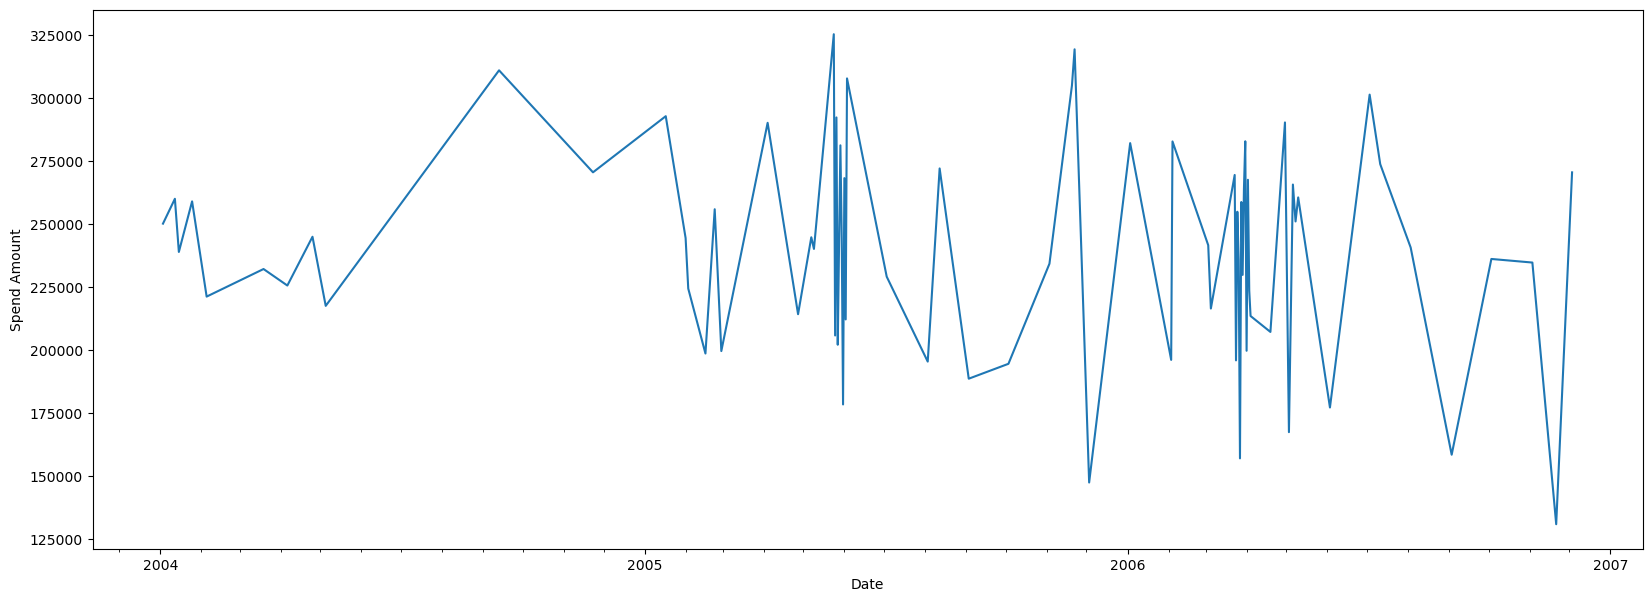

In [18]:
# Visulaize the data
fig, ax = plt.subplots(figsize=(20, 7))
sns.lineplot(x="Date", y="Spend Amount", data=customer_spend, ci=None)

# Make a few changes on how the x_axis is displayed
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

plt.show()


We can see that the total monthly expenditure goes down at the start of the Month of December in the years 2005 and 2006. But why is this? We would expect spending to increases as it nears the holiday season. Let's check the payment dataset for more insights.

##### 5. Payment trends accross the years

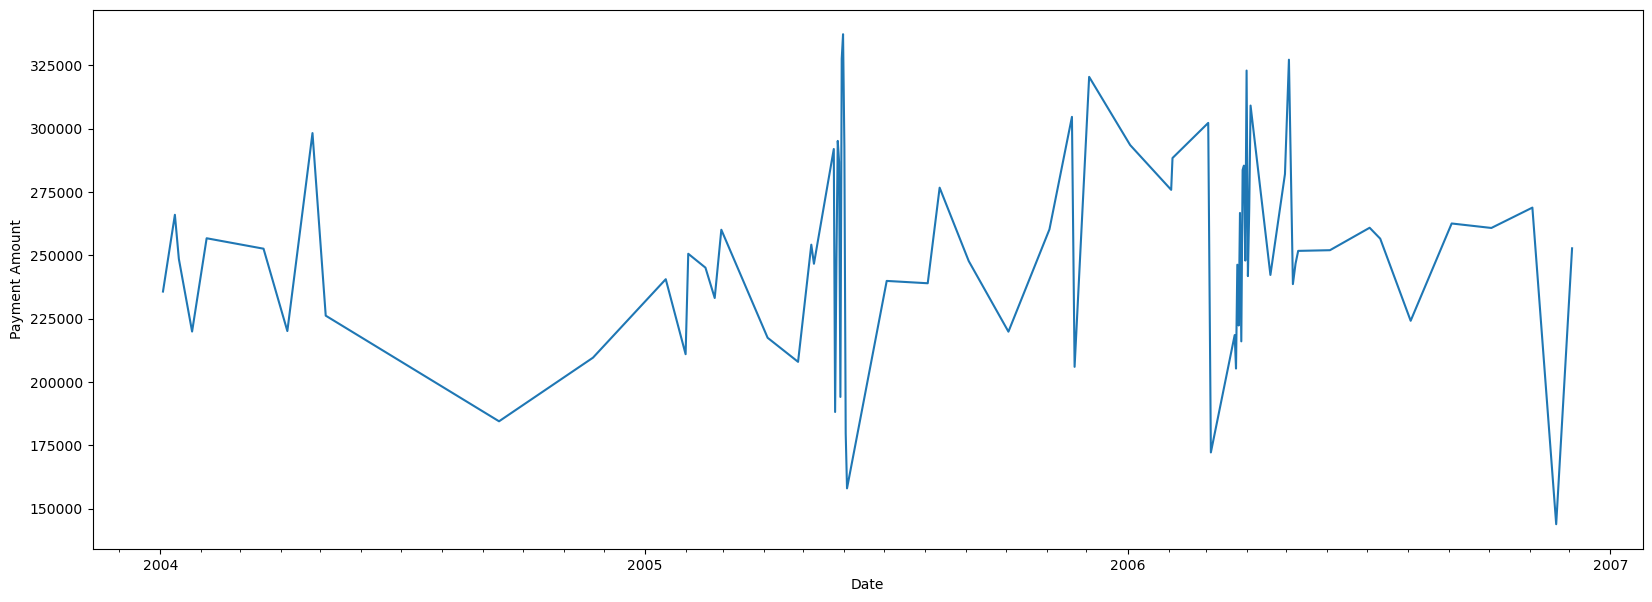

In [19]:
# Visulaize the data
fig, ax = plt.subplots(figsize=(20, 7))
sns.lineplot(x="Date", y="Payment Amount", data=customer_payment, ci=None)

# Make a few changes on how the x_axis is displayed
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

plt.show()


The payment trends do not really tell us much as it also shows that the total monthly payments go down at the start of December.
Let's now check what products are bought the most so we can better understand the trends

##### ** What products do customers mainly buy?

In [20]:
# Group by product and then find the count
product_grouped = customer_spend.groupby(by=["Product Bought"]).size()

print(product_grouped.sort_values(ascending=False))

Product Bought
PETRO           200
CAMERA          160
FOOD            160
AIR TICKET      147
TRAIN TICKET    132
SHOPPING        113
BUS TICKET       99
CLOTHES          95
JEWELLERY        95
MOVIE TICKET     76
RENTAL           76
BIKE             49
AUTO             40
CAR              30
SANDALS          28
dtype: int64


Airtickets are among the top products customers buy and this matches the expenditure trend since we expect most people travel during summer on the months of June and July.

##### ****Hypothetical Situation**
Let's compute the profit the credit card company made each month

In [21]:
# Merge the customer, expenditure and payment data sets
# all_customer_info = customer_df.merge(right=((customer_spend.merge(right=customer_payment, how='inner', on="Customer")).loc[:,["Customer", "Spend Amount", "Payment Amount"]]), how='inner', on="Customer")
all_customer_info = (customer_df.merge(right=customer_spend.loc[:,["Customer", "Product Bought","Spend Amount"]], how='inner', on="Customer")).merge(right=customer_payment, how='inner', on="Customer")

# Group by year and month
grouped_data = all_customer_info.groupby(by=["Year", "Month"]).sum().loc[:,["Spend Amount", "Payment Amount"]]
# Compute the profit earned
grouped_data["Monthly Profit"] = grouped_data["Payment Amount"] - grouped_data["Spend Amount"]
grouped_data.head()

Spend Amount  Payment Amount  Monthly Profit
Year Month                                              
2004 1      1.715187e+09    1.699210e+09    -15977932.93
     2      1.562344e+08    1.602419e+08      4007528.32
     3      8.258765e+07    8.974470e+07      7157050.02
     4      2.108042e+08    2.285403e+08     17736030.58
     5      1.526538e+08    1.411594e+08    -11494415.17

Although on certain months the credit company seemed to make a negative profit, the net profit over the years was positive as shown below.

In [22]:
net_profit = grouped_data.sum()
print(f"Net profit: {net_profit}")

Net profit: Spend Amount      9.126452e+09
Payment Amount    9.314967e+09
Monthly Profit    1.885144e+08
dtype: float64
